In [1]:
from keras.applications import inception_v3
from keras import backend as K

Using TensorFlow backend.


In [2]:
#禁止训练
K.set_learning_phasearning_phase(0)

In [3]:
model=inception_v3.InceptionV3(weights='imagenet',
                              include_top=False)

In [4]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [5]:
layer_contributions={
    'mixed2':0.2,
    'mixed3':3.,
    'mixed4':2.,
    'mixed5':1.5,
}

In [6]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss =loss+coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [7]:
dream = model.input
grads = K.gradients(loss, dream)[0]
# 梯度计算
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)
# 归一化
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

In [8]:
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [9]:
import numpy as np
step = 0.01  
num_octave = 3  
octave_scale = 1.4  
iterations = 20 
max_loss = 10.
base_image_path = '/Users/wuxilei/Desktop/python/build_deep_learning/wife.jpg'
img = preprocess_image(base_image_path)
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])
for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='final_dream.png')

Processing image shape (647, 612)
...Loss value at 0 : 2.2950346
...Loss value at 1 : 2.9965606
...Loss value at 2 : 3.801032
...Loss value at 3 : 4.617892
...Loss value at 4 : 5.4183254
...Loss value at 5 : 6.2123623
...Loss value at 6 : 6.9555283
...Loss value at 7 : 7.6534123
...Loss value at 8 : 8.308104
...Loss value at 9 : 8.96429
...Loss value at 10 : 9.5699005


/Users/wuxilei/anaconda3/envs/tensorflow_1_x/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app


Processing image shape (907, 857)
...Loss value at 0 : 3.5660977
...Loss value at 1 : 4.9268622
...Loss value at 2 : 6.008698
...Loss value at 3 : 6.9580445
...Loss value at 4 : 7.855249
...Loss value at 5 : 8.680963
...Loss value at 6 : 9.458298


/Users/wuxilei/anaconda3/envs/tensorflow_1_x/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Processing image shape (1270, 1200)
...Loss value at 0 : 3.5334866
...Loss value at 1 : 4.8355727
...Loss value at 2 : 5.9224443
...Loss value at 3 : 6.9185553
...Loss value at 4 : 7.8656588
...Loss value at 5 : 8.741321
...Loss value at 6 : 9.58033


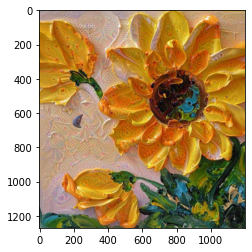

In [10]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()